In [164]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
import copy

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F


import torchvision
from torchvision import models
from torchvision.transforms import Compose, transforms
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix

import itertools


In [157]:
# Constants  
DATA_PATH = "/raid/cs152/adla2017/data/"
CLASSES = ["safe driving",
           "texting - right",
           "talking on the phone - right",
           "texting - left",
           "talking on the phone - left",
           "operating the radio",
           "drinking", 
           "reaching behind",
           "hair and makeup",
           "talking to passenger",
          ]

# Hyperparameters
batch_size = 64
num_epochs = 10
dropout_rate = 0.15
img_size = 128
resnet_size = (224, 224)

In [194]:
# Try to use gpu if available 
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=3)

In [159]:
# TODO: Add transform to normalize data 
# QUESTION: How do we compute mean(s) and SD(s) to perform norm

#  Create augmented transforms
augmented_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(resnet_size, (0.75, 1.0)),
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Imagenet standards
    ])

# Create labeled dataset
data = datasets.ImageFolder(DATA_PATH, transform = augmented_transforms)


In [186]:
# Split dataset into training and validation sets

# TODO: Double check with Prof. Clark that this code does what you think! 

# Compute splitting point for 80% training and 20% validation distribution
num_train = len(data)
indices = list(range(num_train))
split = int(np.floor(0.8 * num_train))

# Randomly shuffle indices
np.random.seed(4747) # fix seed for reproducibility 
np.random.shuffle(indices)

# Split indices into two groups and create a random sampler for each
train_idx, valid_idx = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Save datatset sizes
dataset_sizes = {'train':split, 'val':num_train-split}

# Create loader for training dataset
train_loader = torch.utils.data.DataLoader(
        data, batch_size=batch_size, sampler=train_sampler
    )

# Create loader for validation dataset
valid_loader = torch.utils.data.DataLoader(
    data, batch_size=batch_size, sampler=valid_sampler
)

dataloaders = {'train':train_loader, 'val':valid_loader}

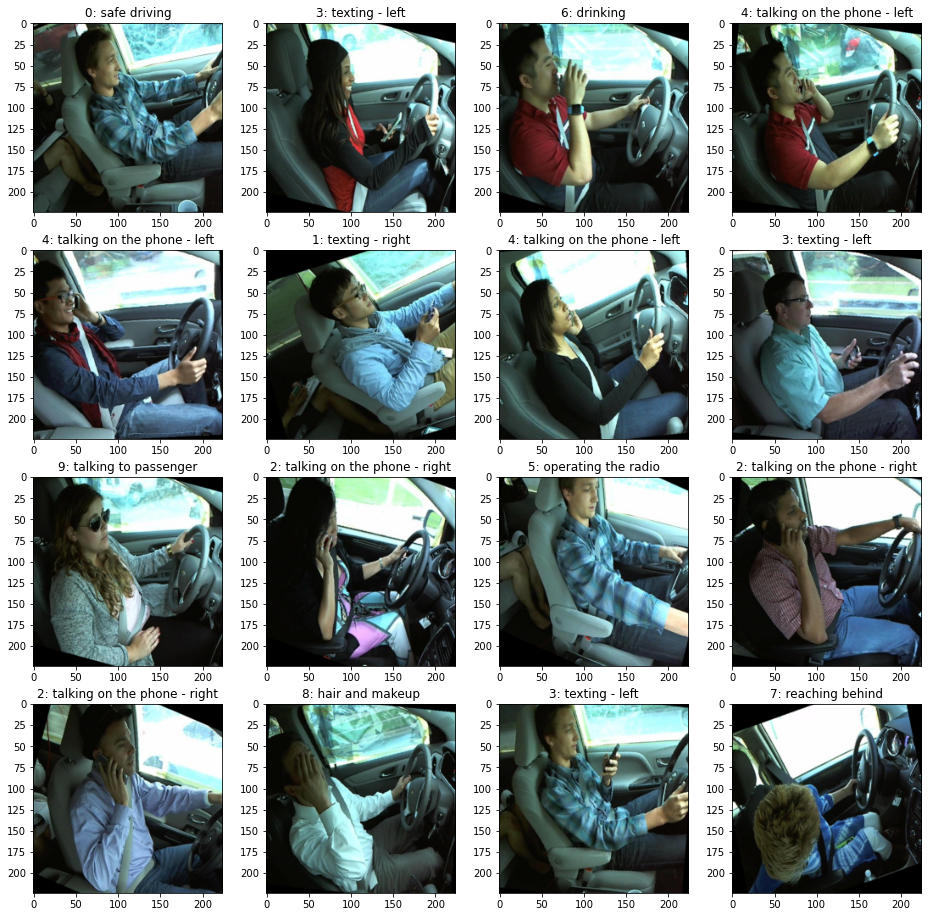

In [161]:
# Get first batch of imgages and labels
images, labels = next(iter(train_loader))

# Plot images and labels in grid 
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = images[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(str(labels[i].item()) + ": " + CLASSES[labels[i].item()])
plt.show()

In [162]:
images.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [163]:
# FUNCTIONS FOR MODEL TRAINING, EVAL, and VISUALIZATION

# Function to train given model with specified criterion, optimizer, and parameters
def train_model(model, criterion, optimizer, num_pochs):
    
    history = []
    
    model.to(device)
    
    for epoch in range(num_epochs):

        model.train()
        
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0
        
        correct = 0
        total = 0

        for images, labels in train_loader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            optimizer.zero_grad()

            loss = criterion(outputs, labels)
            train_loss += loss.item()

            predictions = outputs.argmax(dim=1, keepdim=True)
            comparisons = predictions.eq(labels.view_as(predictions))
            total += labels.shape[0]
            correct += int(comparisons.double().sum().item())
            
            loss.backward()
            
            optimizer.step()
        
        train_acc = correct / total
        train_loss = train_loss / total
        
        # Validation loop for each training epoch
        with torch.no_grad():
            
            model.eval()
            correct = 0
            total = 0
            
            for images, labels in valid_loader:

                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                
                # Validation loss
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                
                predictions = outputs.argmax(dim=1, keepdim=True)

                comparisons = predictions.eq(labels.view_as(predictions))
                total += labels.shape[0]
                correct += int(comparisons.double().sum().item())

            valid_acc = correct / total
            valid_loss = valid_loss / total
            
        history.append([train_loss, valid_loss, train_acc, valid_acc])
        
        print(f"Training loss at epoch {epoch}/{num_epochs}:", train_loss)

    print("Finished Training")
    
    # Format history
    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
    
    return model, history


    
# Test model performance
def eval_model(model):
    
    model.eval()
    model.to(device)
    
    correct = 0
    total = 0

    class_correct = [0 for _ in CLASSES]
    class_total = [0 for _ in CLASSES]

    with torch.no_grad():

        for images, labels in valid_loader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = outputs.argmax(dim=1, keepdim=True)

            comparisons = predictions.eq(labels.view_as(predictions))
            for comp, label in zip(comparisons, labels):
                class_correct[label] += comp.item()
                class_total[label] += 1

            total += labels.shape[0]
            correct += int(comparisons.double().sum().item())

    accuracy = correct / total
    print(f"Accuracy on validation set: {correct}/{total} = {accuracy*100:.2f}%")

    for i, cls in enumerate(CLASSES):
        ccorrect = class_correct[i]
        ctotal = class_total[i]
        caccuracy = ccorrect / ctotal
        print(f"  Accuracy on {cls:>5} class: {ccorrect}/{ctotal} = {caccuracy*100:.2f}%")

        
# Show some images and prediction from validation set
def visualize_model(model):

    model.eval()
    model.to(device)
    
    images, labels = next(iter(valid_loader))

    with torch.no_grad(): 
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predictions = outputs.argmax(dim=1, keepdim=True)

    # Plot images and labels in grid 
    w = 10
    h = 10
    fig = plt.figure(figsize=(16, 16))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        img = images[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.detach().cpu().clone().permute(1,2,0))
        plt.title(str(predictions[i].item()) + ": " + CLASSES[predictions[i].item()])
    plt.show()

In [150]:
# Extend resnet model to build our specialized CNN

model = models.resnet18(pretrained = True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
n_inputs = model.fc.in_features
n_classes = len(CLASSES)
    
# Add on classifier
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes))


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train this model
model, history = train_model(model, criterion, optimizer, num_epochs)


Training loss at epoch 0/10: 0.024967020358307796
Training loss at epoch 1/10: 0.01574037297858237
Training loss at epoch 2/10: 0.013169915861253842
Training loss at epoch 3/10: 0.011854732760591473
Training loss at epoch 4/10: 0.011319354375048395
Training loss at epoch 5/10: 0.010629582637009848
Training loss at epoch 6/10: 0.00998871006410891
Training loss at epoch 7/10: 0.009790246551056371
Training loss at epoch 8/10: 0.00932044609346958
Training loss at epoch 9/10: 0.00889473065357622
Finished Training


In [151]:
# Evaluate this model 
eval_model(model)

Accuracy on validation set: 3885/4485 = 86.62%
  Accuracy on safe driving class: 438/524 = 83.59%
  Accuracy on texting - right class: 374/423 = 88.42%
  Accuracy on talking on the phone - right class: 402/454 = 88.55%
  Accuracy on texting - left class: 412/474 = 86.92%
  Accuracy on talking on the phone - left class: 448/478 = 93.72%
  Accuracy on operating the radio class: 415/446 = 93.05%
  Accuracy on drinking class: 391/467 = 83.73%
  Accuracy on reaching behind class: 369/396 = 93.18%
  Accuracy on hair and makeup class: 260/380 = 68.42%
  Accuracy on talking to passenger class: 376/443 = 84.88%


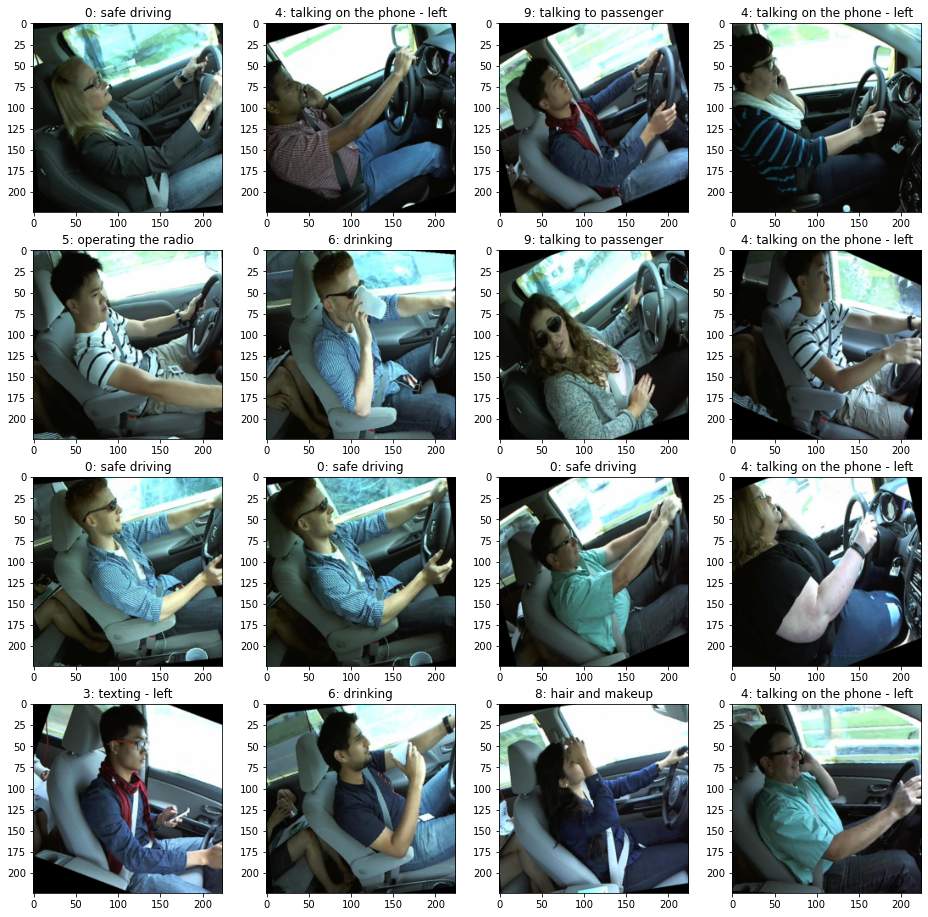

In [152]:
# Visualize the results of training for this model
visualize_model(model)

In [153]:
history

,train_loss,valid_loss,train_acc,valid_acc
0,0.024967,0.015799,0.460505,0.711706
1,0.015740,0.012104,0.666481,0.750279
2,0.013170,0.010368,0.719661,0.778372
3,0.011855,0.009744,0.742628,0.789744
4,0.011319,0.009723,0.753442,0.806689
5,0.010630,0.008068,0.773845,0.837681
6,0.009989,0.007561,0.786610,0.843924
7,0.009790,0.007318,0.790735,0.849498
8,0.009320,0.007381,0.799766,0.849052
9,0.008895,0.006663,0.806790,0.867336


Text(0.5, 1.0, 'Training and Validation Accuracy')

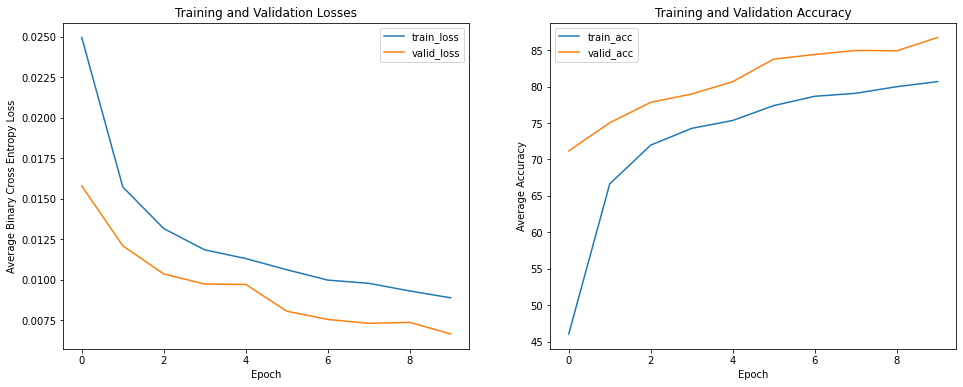

In [155]:
time_series = plt.figure(figsize=(16,6))

time_series.add_subplot(1,2,1)
for c in ['train_loss', 'valid_loss']:
    plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Binary Cross Entropy Loss')
plt.title('Training and Validation Losses')

time_series.add_subplot(1,2,2)
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')


In [233]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [236]:
# Plot confusion matrix for our model
preds = []
targs = []

model = model.cuda()

for images, labels in valid_loader:
    targs += labels
    images, labels = images.cuda(), labels.cuda()
    outputs = model(images)
    predictions = outputs.argmax(dim=1, keepdim=True)
    preds += predictions.cpu()

cm = confusion_matrix(targs, preds)

Confusion matrix, without normalization
[[450   7   0  12  19   8   1   1   4  22]
 [ 10 377   1   7   4   0   9   4   6   5]
 [  5   5 402   0   9   0  13   4  13   3]
 [ 11   4   0 410  34   4   4   0   0   7]
 [ 11   3   2  10 445   0   0   4   1   2]
 [  9   5   0   4   9 405   2   3   2   7]
 [  4  26  12   1   8   1 384   2  23   6]
 [  3   4   0   0   5   1   1 368   3  11]
 [ 17  11  16   5  23   3  16  14 258  17]
 [ 32   5   0   3   4   4   0   5   1 389]]


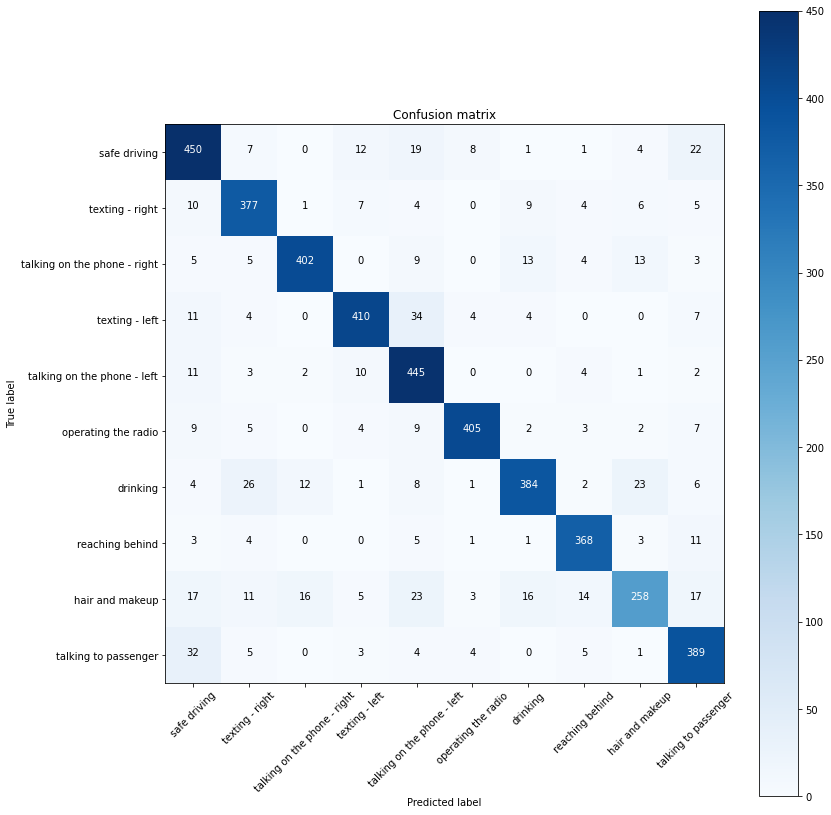

In [237]:
plot_confusion_matrix(cm, CLASSES)